In [1]:
import numpy as np
from scipy.special import softmax
import time
import matplotlib.pyplot as plt

In [2]:
def one_hot_encoding(x_vector, K, char_encoding):
    X = np.zeros((K ,len(x_vector)))
    x_encoding = [char_encoding[i] for i in x_vector]
    for idx, x in enumerate(x_encoding):
        X[x,idx]=1
    return X

# Assignment 4: Vanilla Recurrent Neural Network


A RNN is a neural network which mainly works for processing sequential data. RNN models a dynamic system where the hidden state h at time t  depends on the input x at time t an also on the previous state h at time t-1. RNNs use hidden variables as a memory to capture long term information about a sequence.

## 0.1 Read in the data and get it ready

In [3]:
book_fname='data/goblet_book.txt'

In [4]:
book_data = open(book_fname, encoding='utf-8').read()

In [5]:
book_chars=''.join(sorted(list(set(book_data))))
K=len(book_chars) #len of all unique characters e.g"' abcdefghijklmnopqrstuvwxyz".

In [6]:
print(len(book_data))
print(book_chars)
print(K)

1107542
	
 !"'(),-./01234679:;?ABCDEFGHIJKLMNOPQRSTUVWXYZ^_abcdefghijklmnopqrstuvwxyz}ü•
80


In [7]:
#dict key: letter, value letter idx.
char_to_int = dict((letter, idx) for idx, letter in enumerate(book_chars))
#dict key: letter idx, value letter.
int_to_char = dict((idx, letter) for idx, letter in enumerate(book_chars))

In [8]:
print(char_to_int)

{'\t': 0, '\n': 1, ' ': 2, '!': 3, '"': 4, "'": 5, '(': 6, ')': 7, ',': 8, '-': 9, '.': 10, '/': 11, '0': 12, '1': 13, '2': 14, '3': 15, '4': 16, '6': 17, '7': 18, '9': 19, ':': 20, ';': 21, '?': 22, 'A': 23, 'B': 24, 'C': 25, 'D': 26, 'E': 27, 'F': 28, 'G': 29, 'H': 30, 'I': 31, 'J': 32, 'K': 33, 'L': 34, 'M': 35, 'N': 36, 'O': 37, 'P': 38, 'Q': 39, 'R': 40, 'S': 41, 'T': 42, 'U': 43, 'V': 44, 'W': 45, 'X': 46, 'Y': 47, 'Z': 48, '^': 49, '_': 50, 'a': 51, 'b': 52, 'c': 53, 'd': 54, 'e': 55, 'f': 56, 'g': 57, 'h': 58, 'i': 59, 'j': 60, 'k': 61, 'l': 62, 'm': 63, 'n': 64, 'o': 65, 'p': 66, 'q': 67, 'r': 68, 's': 69, 't': 70, 'u': 71, 'v': 72, 'w': 73, 'x': 74, 'y': 75, 'z': 76, '}': 77, 'ü': 78, '•': 79}


In [9]:
print(int_to_char)

{0: '\t', 1: '\n', 2: ' ', 3: '!', 4: '"', 5: "'", 6: '(', 7: ')', 8: ',', 9: '-', 10: '.', 11: '/', 12: '0', 13: '1', 14: '2', 15: '3', 16: '4', 17: '6', 18: '7', 19: '9', 20: ':', 21: ';', 22: '?', 23: 'A', 24: 'B', 25: 'C', 26: 'D', 27: 'E', 28: 'F', 29: 'G', 30: 'H', 31: 'I', 32: 'J', 33: 'K', 34: 'L', 35: 'M', 36: 'N', 37: 'O', 38: 'P', 39: 'Q', 40: 'R', 41: 'S', 42: 'T', 43: 'U', 44: 'V', 45: 'W', 46: 'X', 47: 'Y', 48: 'Z', 49: '^', 50: '_', 51: 'a', 52: 'b', 53: 'c', 54: 'd', 55: 'e', 56: 'f', 57: 'g', 58: 'h', 59: 'i', 60: 'j', 61: 'k', 62: 'l', 63: 'm', 64: 'n', 65: 'o', 66: 'p', 67: 'q', 68: 'r', 69: 's', 70: 't', 71: 'u', 72: 'v', 73: 'w', 74: 'x', 75: 'y', 76: 'z', 77: '}', 78: 'ü', 79: '•'}


# 0.2 Set hyper-parameters & initialize the RNN's parameters:

In [10]:
def init_param(book_data, m, eta, seq_length, sig):
    data = {}
    model_param= {}
    data['book_data'] = book_data
    data['K'] = len(''.join(sorted(list(set(data['book_data'])))))
    model_param['m'] = m
    model_param['eta'] = eta
    model_param['seq_length'] = seq_length
    model_param['sig'] = sig
    h_0 = np.zeros((model_param['m'],1))
    return data, model_param

In [11]:
def init_weights(model_param, data):
    weights = {}
    weights['V'] = np.random.normal(loc=0.0, scale=model_param['sig'],
                                       size=( data['K'], model_param['m']))  #Kxm
    weights['W'] = np.random.normal(loc=0.0, scale= model_param['sig'],
                                       size=(model_param['m'], model_param['m'])) #mxm
    weights['U'] = np.random.normal(loc=0.0, scale= model_param['sig'], 
                                       size=( model_param['m'], data['K'])) #mxK
    weights['c'] = np.zeros((data['K'],1)) #Kx1
    weights['b'] = np.zeros((model_param['m'],1)) #mx1 
    return weights

In [12]:
data, model_param = init_param(book_data, m=5, eta=0.1, seq_length=25, sig=0.01)
weights = init_weights(model_param, data)

In [13]:
#The label for an input character is the next character of the text,
#e.g: first input letter = H -> label : A
#second input letter = A
X_chars = book_data[0:model_param['seq_length']]
print(X_chars)
Y_chars = book_data[1:model_param['seq_length']+1]
print(Y_chars)

HARRY POTTER AND THE GOBL
ARRY POTTER AND THE GOBLE


In [14]:
X = one_hot_encoding(X_chars, data['K'], char_to_int) #Kxseq_length
Y = one_hot_encoding(Y_chars, data['K'], char_to_int) #Kxseq_length

In [15]:
x_encoding = [char_to_int[i] for i in X_chars]
y_encoding = [char_to_int[i] for i in Y_chars]

In [16]:
print(x_encoding == np.argmax(X, 0))
print(y_encoding == np.argmax(Y, 0))

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True]


In [17]:
print(X.shape, Y.shape)

(80, 25) (80, 25)


# 0.3 Synthesize text from your randomly initialized RNN:

In [18]:
def synthesize_char_sequence(x0, h_0, weights, n):
    h, x = h_0, x0
    xnext = np.zeros((x0.shape[0], n))
    for i in range(n):
        a =  np.dot(weights['W'], h) + np.dot(weights['U'], x) + weights['b'] #mx1
        h = np.tanh(a) #mx1
        o = np.dot(weights['V'], h) + weights['c'] #Kx1
        p = softmax(o)
        cp = np.cumsum(p) #k,
        a = np.random.uniform(0, 1, 1)
        ixs = np.where(cp - a > 0) #idx list
        ii = ixs[0][0]
        xnext[ii,i] = 1
        x = xnext[:, i].reshape(-1, 1) #Kx1
    return xnext

In [19]:
x0 = np.zeros((data['K'],1)) #dummy input vector Kx1
x0[char_to_int['.']] = 1
h_0 = np.zeros((model_param['m'],1))
xnext = synthesize_char_sequence(x0, h_0, weights, n=180)

In [20]:
#sanity check
print(xnext.shape)
sum(np.sum(xnext,0))

(80, 180)


180.0

In [21]:
np.argmax(xnext, axis=0)

array([68, 24, 12, 27, 42, 44,  0, 22, 39,  7, 18, 19, 57, 50,  4, 32, 13,
       32, 36, 14, 53, 69, 29, 60, 43, 53, 38, 31, 37, 32, 32, 15,  2, 40,
       37,  6,  1, 40, 36, 66, 62, 24, 17,  0, 39, 71, 14, 46,  2, 76, 54,
       31, 56, 30, 35,  5, 68, 69, 66, 51, 57, 63, 55, 73, 56, 75, 27,  7,
       35, 65, 22, 47, 32, 28, 40, 64, 45, 15, 55, 33, 60, 63, 66, 28, 20,
       60, 56, 62, 26, 40, 62, 24, 40, 50, 28, 29,  2, 46, 70, 77,  4, 56,
       15, 15, 15, 59, 71,  1, 66, 37, 21, 38, 24, 61, 77, 59, 57, 34, 77,
       44, 38, 30, 10,  9, 20, 24, 66, 36, 40, 11, 65, 73, 42, 67,  7, 47,
       52, 22, 62, 79,  3, 12, 77, 41, 32, 57, 27, 14, 53, 48,  1, 37, 61,
       66, 26, 26, 24, 57, 29, 62, 42, 52, 55, 23, 63, 34, 37, 46, 11, 25,
       52, 22, 16, 30, 67, 78, 39, 52, 45, 75])

In [22]:
print(''.join(int_to_char[i] for i in np.argmax(xnext, axis=0)))

rB0ETV	?Q)79g_"J1JN2csGjUcPIOJJ3 RO(
RNplB6	Qu2X zdIfHM'rspagmewfyE)Mo?YJFRnW3eKjmpF:jflDRlBR_FG Xt}"f333iu
pO;PBk}igL}VPH.-:BpNR/owTq)Yb?l•!0}SJgE2cZ
OkpDDBgGlTbeAmLOX/Cb?4HqüQbWy


# 0.4 Implement the forward & backward pass of back-prop:

In [23]:
def compute_loss(weights, context_vect, X, Y):
    ce_loss = 0
    a_t, h_t, o_t, p_t = {}, {}, {}, {}
    h_t[-1] = context_vect
    n_T = X.shape[1]
    for t in range(n_T):
        a_t[t] = np.dot(weights['W'], h_t[t-1]) + np.dot(weights['U'], X[:,t].reshape(-1,1)) + weights['b'] #mx1
        h_t[t] = np.tanh(a_t[t]) #mx1
        o_t[t] = np.dot(weights['V'], h_t[t]) + weights['c'] #Kx1
        p_t[t] = np.exp(o_t[t]) / np.matmul(np.ones((1, o_t[t].shape[0])), np.exp(o_t[t])) #Kx1
        ce_loss += -np.log(np.dot(Y[:, t].reshape(1, -1), p_t[t]))
    return h_t, p_t, ce_loss[0]


In [24]:
def compute_gradients(weights, context_vect, X_, Y_):
    #total number of states t
    n_T = X_.shape[1]
    #compute loss
    h_t, p_t, ce_loss = compute_loss(weights, context_vect, X_, Y_)
    
    # backward pass
    d_b, d_c = np.zeros_like(weights['b']), np.zeros_like(weights['c'])
    d_ot, d_at, d_ht = {}, {}, {}
    grads = {}
    grads['V'] = 0
    grads['W'] = 0
    grads['U'] = 0
    grads['c'] = np.zeros_like(weights['c']) #Kx1
    grads['b'] = np.zeros_like(weights['b'])
    
    #as d_ht at time T = d_ot[t] * V, I initiallize d_a_next (d_at[t+1]) at zero,
    #and later assign d_a_next  = d_at[t] 
    #this as d_ht at time t = d_ot[t] * V + d_at[t+1] * W 
    d_a_next = np.zeros((model_param['m'], 1))
    
    # we need to iterate backwards as for computing d_ht[t] we need d_at[t+1]
    for t in reversed(range(n_T)):
        d_ot[t] = -(Y_[:,t].reshape(-1, 1) - p_t[t]) #Kx1
        grads['V'] += np.dot(d_ot[t], h_t[t].T) #Kxm
        grads['c'] = grads['c'] + d_ot[t] #Kx1
        d_ht[t] = np.dot(d_ot[t].T, weights['V']).T + np.dot(weights['W'].T, d_a_next) #mx1
        d_at[t] = d_ht[t] * (1 - (h_t[t] * h_t[t])) #mx1
        d_a_next = d_at[t]
        grads['b'] =  grads['b'] + d_at[t] #mx1
        grads['W'] += np.dot(d_at[t], h_t[t-1].T) #mxm
        grads['U'] += np.dot(d_at[t], X_[:,t].reshape(1,-1)) #mxk
    new_context_vector = h_t[n_T - 1].copy()
    
    # to avoid the exploding gradient
    for keys, gradients in grads.items():
        gradients = np.clip(gradients, -5, 5, out=gradients)
    
    return ce_loss[0], grads, new_context_vector


In [25]:
def NumericalGradients(weights_,X_,Y_):
    """
    Numerical gradients using Finite difference Formula.
    """
    h_0 = np.zeros((model_param['m'],1))
    h=1e-4
    numerical_gradients = {}
    for key, weight in weights_.items():
        numerical_gradients[key] = np.zeros_like(weight)
        #each weight(key) has a different dimension
        for i in range(weights_[key].shape[0]):
            for j in range(weights_[key].shape[1]):
                # + h, I could have deep copied 
                weights_[key][i][j] += h
                _, _, l2 = compute_loss(weights_, h_0, X_, Y_)
                # as I have previously modified the weights(+h) I need to substract twice - h
                weights_[key][i][j] -= 2*h
                _, _, l1 = compute_loss(weights_, h_0, X_, Y_)
                #initial weights
                weights_[key][i][j] += h
                numerical_gradients[key][i][j] = (l2-l1) / (2*h)
    return numerical_gradients

In [26]:
def VerifyGradients(analytical_grad_dictionary, numerical_grad_dictionary):
    max_relative_error = {}
    eps = 1e-15
    for (key_i,analit_weight), (key_j,num_weight) in zip(analytical_grad_dictionary.items(), numerical_grad_dictionary.items()):
        max_value = np.maximum(eps, np.absolute(analit_weight) + np.absolute(num_weight))
        max_relative_error[key_i] = np.amax(np.absolute(analit_weight-num_weight) / max_value)
    return max_relative_error

In [27]:
#analytical gradients:
loss, grads, _ = compute_gradients(weights, h_0, X, Y)
#numerical gradients:
numerical_gradients = NumericalGradients(weights,X,Y)

In [28]:
VerifyGradients(grads,numerical_gradients )

{'V': 4.1144612911662657e-07,
 'W': 1.4415513745363808e-06,
 'U': 3.2111687931512057e-07,
 'c': 1.1419375590515373e-09,
 'b': 5.8311830205565415e-09}

# 0.5 Train your RNN using AdaGrad:

In [29]:
def train_model(data, model_param, weights, n_epochs = 10, update_step = 10000, n_=200, save_file = 'none'):
    
    book_data = data['book_data']
    seq_length = model_param['seq_length']
    K = data['K']
    m = model_param['m']
    eta = model_param['eta']
    text_book_length = len(book_data)
    iter_per_epoch= text_book_length // seq_length
    total_num_iterations = n_epochs*iter_per_epoch
    
    m_weights = {}
    for weight_key, weight_matrix in weights.items():
        m_weights[weight_key] = np.zeros_like(weight_matrix)

    train_loss = {}
    smooth_loss = {}
    best_model = {}
    synth = {}
    best_smooth_loss = 43
    e = 0
    h_0 = np.zeros((m, 1))
    
    print(f'epochs = {n_epochs}')
    tic = time.time() 
    for iteration in range(total_num_iterations):

        if iteration == 0 or e > (text_book_length - seq_length - 1):
            h_0 = np.zeros((m, 1))
            e = 0

        #prepare data sequence
        X_chars = book_data[e: e + seq_length]
        Y_chars = book_data[e + 1: e + seq_length + 1]

        X = one_hot_encoding(X_chars, K, char_to_int) #Kxseq_length
        Y = one_hot_encoding(Y_chars, K, char_to_int) #Kxseq_length


        #compute loss and grads
        loss, grads, new_h_0 = compute_gradients(weights, h_0, X, Y)

        smooth_loss_ = loss if e == 0 or iteration == 0 else 0.999 * smooth_loss_ + 0.001 * loss
       
        train_loss[iteration] = loss
        smooth_loss[iteration] = smooth_loss_
        
        if smooth_loss_ < best_smooth_loss:
                best_smooth_loss = smooth_loss_
                best_model['loss'] = loss
                best_model['smooth_loss'] = smooth_loss_
                best_model['pred_text'] = xnext
                best_model['grads'] = grads
                best_model['weights'] = weights
                best_model['h_0'] = h_0
                
        if (iteration - 1) % (update_step) == 0:
            print('-------')
            print(f'iteration = {iteration} / {total_num_iterations}')
            print(f'Smooth loss = {float(smooth_loss_)}')
            print('-------')
            xnext = synthesize_char_sequence(X[:,[0]], h_0, weights, n=n_)
            synth[iteration] = xnext
            print(''.join(int_to_char[i] for i in np.argmax(xnext, axis=0)))

        #apply adaGrad Algorithm
        #It adapts the learning rate to the parameters, performing smaller updates
        for key, weight in weights.items():
            m_weights[key] += grads[key]**2
            weights[key] = weights[key] -  eta  * grads[key] / np.sqrt(m_weights[key] + 1e-8)

        e += seq_length

        # new step context update
        h_0 = new_h_0
    tac = time.time() 
    print(f'training took {tac - tic} seconds')
    
    if save_file == 'none':
        return train_loss, smooth_loss, best_model
    
    np.savez( save_file, train_loss=train_loss, smooth_loss=smooth_loss, best_model=best_model)
    return train_loss, smooth_loss, best_model

In [42]:
data, model_param = init_param(book_data, m=100, eta=0.1, seq_length=25, sig=0.01)
weights = init_weights(model_param, data)

In [43]:
train_loss, smooth_loss, best_model= train_model(data, model_param, weights, 
                                                n_epochs = 10, update_step = 10000, n_=200, 
                                                save_file = 'results_180719')

epochs = 10
-------
iteration = 1 / 443010
Smooth loss = 109.55385914941219
-------
1)OYtFjw
))}VLE0GeWBum,DhTgBtoSYY,}?mvD	Lj^kp4(hXPQ1ü4_.pOeHGTLmGa,AMhTP•wHA.ANDz!eFLD?"oi;p9XfLE4ü/29Qo.mo4,X	w'/.UBEVkmS'LXFEE /L	)T4sN(h'	Y;AkJ.A'7hbx)4y7
B1kY9?9:A0"yiD09R•.jj(;RFHW_rw0BIwW3l)cyVü
-------
iteration = 10001 / 443010
Smooth loss = 52.60691545687797
-------
nours Ro her. dfoat."Wearlillor. Wayfien tha wharmid acoun, an, Wharkieg on of homas.  aikey eron theassear of a rus wor a chashillllerch the bow hilg  fom Harry . . . . Rmathis an istnle cot andy, an
-------
iteration = 20001 / 443010
Smooth loss = 49.303036035218355
-------
the hire lowril.  HAr- said?"

Bar had led,"
Hagry wiseely tcoul allt.
"E'g.  Mad Petsing hid Parcor Hhorishert slakryra ar?"

"Htimer for her dicker had set dely.
"Alling to kid mith dlefermanser?" H
-------
iteration = 30001 / 443010
Smooth loss = 47.94362252706097
-------
icking it taingy suareew pellodabing to goolvering the fiked that Rot.  To in morntin h

-------
iteration = 300001 / 443010
Smooth loss = 39.60197392589072
-------
on'y it," said. Yeh, and could hands have grourderremiLf roundiesbant of Fide had 't'r half . ..." He Side Hagrid boid in he long Dobbysing Harry.  "He mensaed.
"You nonkeding soophto taps.
"When Croo
-------
iteration = 310001 / 443010
Smooth loss = 39.72945001982676
-------
 villing zingal come at than shor keen to ened that time you modd fret, Krusk'ur him eaticur.  "Ar.  Co retid won't of oP Harry abaggread it," said Dumbledore's lult slad be osed I bin as to on the 2i
-------
iteration = 320001 / 443010
Smooth loss = 40.989638140956956
-------
wsice uplarg was sore.
Krigning..
"If into the thike, his never enosser," sarry move me elooking wanding them, liax the come Jang, permon't on the Broom, ecked the curmys.
"Yeah, "On ragme-greet Krum 
-------
iteration = 330001 / 443010
Smooth loss = 40.785007607032945
-------
tap,"  he dufforning feop e'choy.
Neven sod of Mrs peen at to the was and again Cack robed 

In [44]:
best_model['smooth_loss']

38.30192759989202

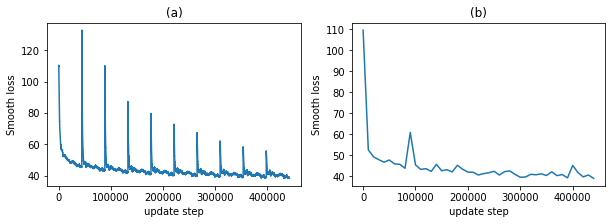

In [95]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,3))
ax1.plot(smooth_loss.keys(), list(smooth_loss.values()), color='tab:blue')
ax1.set_title('(a)')
ax1.set_ylabel('Smooth loss')
ax1.set_xlabel('update step')
ax2.plot([i for i in range(1,len(smooth_loss.keys()),10000)], 
         [smooth_list[i] for i in [i for i in range(1,len(smooth_loss.keys()),10000)]],
         color='tab:blue')
ax2.set_title('(b)')
ax2.set_ylabel('Smooth loss')
ax2.set_xlabel('update step')
plt.savefig('test')
plt.show()

In [46]:
xnext = synthesize_char_sequence(X[:,[0]], best_model['h_0'], best_model['weights'], n=1000)
print(''.join(int_to_char[i] for i in np.argmax(xnext, axis=0)))

Arne greep.  It and Snapplimple Vobled to Harry exatp and sud how Weasley swenter.
"Well, but have chilly down awainuy to his smyong the Ro.  Ansts-out Fudd the polwardly," seersing to the fectort at asmeres and me brenss asseng over -  no!"
"Mock.
"Com over us only not almost, my the nears, gobgley, but when the momens the. . .
"Beat, I'll below, his when yet half feet was cooked enougn your.  Whicking back.  He nelling; is don't, him."
Fudd cood, way minateen still pleet to where, what," said Moody orking his nis?, Fred loiden.
Harry turned him.  Fther.  Mrs. Weasley would names. No.  bas, went thenesler he Num!  Hordt flat and suir.
Disstusenge pleas.  "Hogkers din on the Geove had hest of didfer, allod.  AGon ort to clos to heape.
" you happened,""Ghe someysosped where, sal sudnermally were levere.  Yo Ron be dot they of Lure thedely, vidding one of a mistering of sours looked its.
"Why and Fred thit's would trien they went.
He?"
Bo non, I."R Harry's, that Hogly voissly.  bas talki